# SUPERVISED
In this part we will start to develop models based on the EDA made before 

# Introduction

## Import Libraries

In [114]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.feature_selection import RFE
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Output the versions of all libraries
import sys
import sklearn
import xgboost
import tensorflow as tf
import matplotlib as plt2


versions = {
    'Python': sys.version,
    'Pandas': pd.__version__,
    'NumPy': np.__version__,
    'Scikit-learn': sklearn.__version__,
    'XGBoost': xgboost.__version__,
    'TensorFlow': tf.__version__,
    'Statsmodels': sm.__version__,
    'Seaborn': sns.__version__,
    'Matplotlib': plt2.__version__,
}

versions

{'Python': '3.9.6 (default, Feb  3 2024, 15:58:27) \n[Clang 15.0.0 (clang-1500.3.9.4)]',
 'Pandas': '2.2.2',
 'NumPy': '1.26.4',
 'Scikit-learn': '1.5.1',
 'XGBoost': '2.1.1',
 'TensorFlow': '2.17.0',
 'Statsmodels': '0.14.2',
 'Seaborn': '0.13.2',
 'Matplotlib': '3.9.2'}

## Pre-data processing
In this section, we will remove the data that is not useful for our analysis, such as the artist name, track name, album name, track ID, and the explicit column. The explicit column is also dropped again because it is a binary variable that is highly imbalanced and skewed towards one side.

In [115]:
df = pd.read_csv('Dataset/dataset_1.csv')

# Remove non-numeric and unnecessary columns
df.drop(['track_id', 'artists', 'album_name', 'track_name', 'explicit'], axis=1, inplace=True)

# Check for and handle missing values
df.dropna(inplace=True)  # Remove rows with missing values if any

In [116]:
df.head(6)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,55,149610,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,57,210826,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,71,201933,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,82,198853,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic
5,58,214240,0.688,0.4810,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.666,98.017,4,acoustic


In [117]:
# Move 'track_genre' to the first column
columns = ['track_genre'] + [col for col in df.columns if col != 'track_genre']
df = df[columns]

df_original = df.copy()

## Data Preparation
Before we start modeling, let's prepare the dataset by loading it, inspecting it, and making any necessary preprocessings such as handling missing values and normalizing or standardizing the data.

In [118]:
features = df.columns[1:]  # All columns except the first one

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
df[features] = scaler.fit_transform(df[features])

# Display the first few rows of the updated DataFrame
df.head()

,track_genre,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,acoustic,1.794706,-0.001588,0.651248,-0.707666,-1.209044,0.320224,-1.315453,0.519395,-0.853005,-0.530503,0.720208,0.960042,-1.149508,0.221028
1,acoustic,0.930563,-0.733846,-0.818175,-1.867829,-1.209044,-1.727478,0.760195,-0.089186,1.811829,-0.530489,-0.595490,-0.764589,-1.497543,0.221028
2,acoustic,1.026579,-0.180822,-0.714856,-1.108807,-1.490150,-0.263105,0.760195,-0.277143,-0.321712,-0.530506,-0.513579,-1.330484,-1.536158,0.221028
3,acoustic,1.698690,-0.261161,-1.702124,-2.286274,-1.490150,-1.977364,0.760195,-0.454152,1.755054,-0.530285,-0.436787,-1.241942,1.981836,-2.057206
4,acoustic,2.226777,-0.288986,0.318332,-0.778455,-0.927938,-0.252758,0.760195,-0.305428,0.452220,-0.530506,-0.688152,-1.149551,-0.080440,0.221028


In [119]:
X = df.drop('track_genre', axis=1)  # Features
y = df['track_genre']  # Target variable

In [120]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In this part we are scaling our data to help different models perform better, then we ensure to encode our target categorical variable and finally split our data into a train and test set ! (80-20%)

In [121]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


# Initial Model Development: Raw Model Testing

## Baseline Models (No Feature Engineering Yet)

### Logistic Regression (Multiclass)

In [50]:
model_logReg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

model_logReg.fit(X_train, y_train)

y_pred_log = model_logReg.predict(X_test)

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [51]:
# Step 6: Evaluate the Model
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log, zero_division=0) )
print("Accuracy:", accuracy_score(y_test, y_pred_log))

[[17  0  2 ...  1  0  8]
 [ 1 29  0 ...  1  1  0]
 [ 1  0  0 ...  0  1  2]
 ...
 [ 0  8  0 ... 11  4  4]
 [ 1  0  3 ...  1 18  1]
 [ 2  0  2 ...  0  0 52]]
              precision    recall  f1-score   support

           0       0.08      0.09      0.09       182
           1       0.25      0.15      0.18       197
           2       0.00      0.00      0.00       167
           3       0.00      0.00      0.00       148
           4       0.25      0.31      0.28       181
           5       0.03      0.01      0.02       166
           6       0.35      0.45      0.40       182
           7       0.31      0.29      0.30       221
           8       0.00      0.00      0.00       141
           9       0.16      0.04      0.07       215
          10       0.18      0.18      0.18       187
          11       0.00      0.00      0.00       177
          12       0.17      0.18      0.17       200
          13       0.30      0.42      0.35       204
          14       0.23      0.33

The overall accuracy of the model is 21.65%, meaning it correctly classified about 22% of the samples. The macro average, which treats all classes equally, shows an F1-score of 0.17, and the weighted average, which considers the number of samples per class, shows an F1-score of 0.19. These low scores suggest the model struggles with accurate classification across most genres.


### Ridge - L2 Regularization 

In the given context, L2 regularization (Ridge) is used after running logistic regression with the lbfgs solver to prevent overfitting by penalizing large coefficients, ensuring that the model generalizes better to new data by maintaining small, balanced weights across all features.

In [56]:
# L2 regularization with different values of C
for c in [1.0,3.0,5.0]:
    print(f"Training model with C={c} using L2 regularization")
    model_logReg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, penalty='l2', C=c)
    model_logReg.fit(X_train, y_train)
    
    y_pred_log = model_logReg.predict(X_test)
    
    # Evaluating the model
    #print(confusion_matrix(y_test, y_pred_log))
    print("Accuracy:", accuracy_score(y_test, y_pred_log))
    print(classification_report(y_test, y_pred_log))
    print("\n")

Training model with C=1.0 using L2 regularization


/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.21664504540465024
              precision    recall  f1-score   support

           0       0.08      0.09      0.09       182
           1       0.25      0.15      0.18       197
           2       0.00      0.00      0.00       167
           3       0.00      0.00      0.00       148
           4       0.25      0.31      0.28       181
           5       0.03      0.01      0.02       166
           6       0.35      0.45      0.40       182
           7       0.31      0.29      0.30       221
           8       0.00      0.00      0.00       141
           9       0.16      0.04      0.07       215
          10       0.18      0.18      0.18       187
          11       0.00      0.00      0.00       177
          12       0.17      0.18      0.17       200
          13       0.30      0.42      0.35       204
          14       0.23      0.33      0.27       186
          15       0.17      0.21      0.19       191
          16       0.40      0.33      0.36       1

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

Accuracy: 0.21669494062468816
              precision    recall  f1-score   support

           0       0.08      0.09      0.08       182
           1       0.24      0.15      0.18       197
           2       0.00      0.00      0.00       167
           3       0.00      0.00      0.00       148
           4       0.25      0.31      0.28       181
           5       0.03      0.01      0.02       166
           6       0.36      0.45      0.40       182
           7       0.30      0.29      0.29       221
           8       0.00      0.00      0.00       141
           9       0.15      0.04      0.07       215
          10       0.18      0.18      0.18       187
          11       0.00      0.00      0.00       177
          12       0.17      0.19      0.18       200
          13       0.30      0.41      0.35       204
          14       0.23      0.33      0.27       186
          15       0.17      0.21      0.19       191
          16       0.40      0.33      0.36       1

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

Accuracy: 0.21689452150483984
              precision    recall  f1-score   support

           0       0.08      0.09      0.08       182
           1       0.24      0.15      0.18       197
           2       0.00      0.00      0.00       167
           3       0.00      0.00      0.00       148
           4       0.25      0.31      0.28       181
           5       0.03      0.01      0.02       166
           6       0.36      0.45      0.40       182
           7       0.31      0.29      0.30       221
           8       0.00      0.00      0.00       141
           9       0.16      0.04      0.07       215
          10       0.18      0.18      0.18       187
          11       0.00      0.00      0.00       177
          12       0.17      0.19      0.18       200
          13       0.30      0.41      0.35       204
          14       0.23      0.33      0.27       186
          15       0.17      0.21      0.19       191
          16       0.40      0.33      0.36       1

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

### Comments

#### Without Regularization (penalty='none'):

- Accuracy: 0.2166 (approximately 21.66%)
The model's precision, recall, and F1-score for different classes vary significantly, with some classes performing relatively well (e.g., class 18, class 42) while others perform poorly (e.g., class 2, class 3).
#### With L2 Regularization (penalty='l2', C=5)
- Accuracy: 0.2167 (approximately 21.67%)
Adding L2 regularization with a strength parameter C=5 did not significantly change the accuracy or the other evaluation metrics. The slight increase in accuracy is negligible.
**Key Observations:**
- Model Performance: The overall accuracy and F1-scores are low, indicating that the model struggles with this classification task. This could be due to several reasons such as class imbalance, insufficient data, overly complex classes, or lack of feature engineering.

Class-wise Performance: Some classes have reasonable precision and recall, while others are very low or even zero. This suggests that the model may not be learning effectively for all classes.
Effect of Regularization: The addition of L2 regularization with C=5 does not seem to make a significant difference. This could indicate that the model's performance is not highly sensitive to regularization for this specific dataset and feature set.

## Advanced model: Raw testing

### Random Forrest 

In [57]:
rf_model_raw = RandomForestClassifier(n_estimators=500, random_state=42)

# Train the model
rf_model_raw.fit(X_train, y_train)

# Predict on the test set
y_pred_rf_raw = rf_model_raw.predict(X_test)

# Evaluate the model
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_raw))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_raw))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_raw, target_names=label_encoder.classes_))

Random Forest Classifier
Accuracy: 0.3123939726574194
Confusion Matrix:
 [[38  1  0 ...  1  2  8]
 [ 0 70  0 ... 10  4  0]
 [ 0  0  1 ...  1  2  1]
 ...
 [ 1 21  0 ... 38  0  2]
 [ 4  0  3 ...  2 83  1]
 [ 3  0  5 ...  0  0 73]]
Classification Report:
                    precision    recall  f1-score   support

         acoustic       0.23      0.21      0.22       182
         afrobeat       0.41      0.36      0.38       197
         alt-rock       0.01      0.01      0.01       167
      alternative       0.00      0.00      0.00       148
          ambient       0.23      0.22      0.22       181
            anime       0.19      0.18      0.18       166
      black-metal       0.50      0.59      0.54       182
        bluegrass       0.45      0.61      0.52       221
            blues       0.09      0.05      0.06       141
           brazil       0.07      0.07      0.07       215
        breakbeat       0.51      0.42      0.46       187
          british       0.10      0.06

#### Grid Search - Hypertuning 

In this part, we won't compute too many parameters because of the actual computer performances and matter of time. Also regarding the cross validation won't be performed as I don't fidn relevant at this stage of the project. 

In [122]:
# Define a smaller grid of hyperparameters
param_grid = {
    'n_estimators': [100,500],          # Number of trees in the forest
    'max_depth': [None, 10, 20],         # Maximum depth of the tree
    'min_samples_split': [2, 5],         # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2]         # Minimum number of samples required at each leaf node
}

# Initialize the Random Forest model
rf_model_raw_tuning = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with the smaller parameter grid
grid_search = GridSearchCV(estimator=rf_model_raw_tuning, param_grid=param_grid, cv=2, n_jobs=-1, verbose=0)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Use the best model found
best_rf_model_raw = grid_search.best_estimator_

# Predict with the best model
y_pred_best_raw = best_rf_model_raw.predict(X_test)

# Evaluate the best model
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best_raw))
print(confusion_matrix(y_test, y_pred_best_raw))
print(classification_report(y_test, y_pred_best_raw))

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Model Accuracy: 0.3105478495160164
[[34  2  1 ...  1  1  8]
 [ 0 68  0 ... 10  4  0]
 [ 0  0  1 ...  1  2  1]
 ...
 [ 0 22  0 ... 38  0  2]
 [ 3  0  3 ...  4 82  1]
 [ 2  0  5 ...  0  1 71]]
              precision    recall  f1-score   support

           0       0.20      0.19      0.19       182
           1       0.40      0.35      0.37       197
           2       0.01      0.01      0.01       167
           3       0.00      0.00      0.00       148
           4       0.22      0.23      0.22       181
           5       0.14      0.14      0.14       166
           6       0.51      0.59      0.55       182
           7       0.45      0.61      0.51       221
           8       0.05      0.03      0.04       141
           9       0.08      0.07      0.07       215
          10       0.49      0.43      0.46       187
          11       0.07      0.05      0.06       177
          12       0.32      0.30      0.31       200
          13       0.54      0.50      0.52    

### XGBoost

#### Raw basic model

Final Accuracy on Test Data: 0.3261


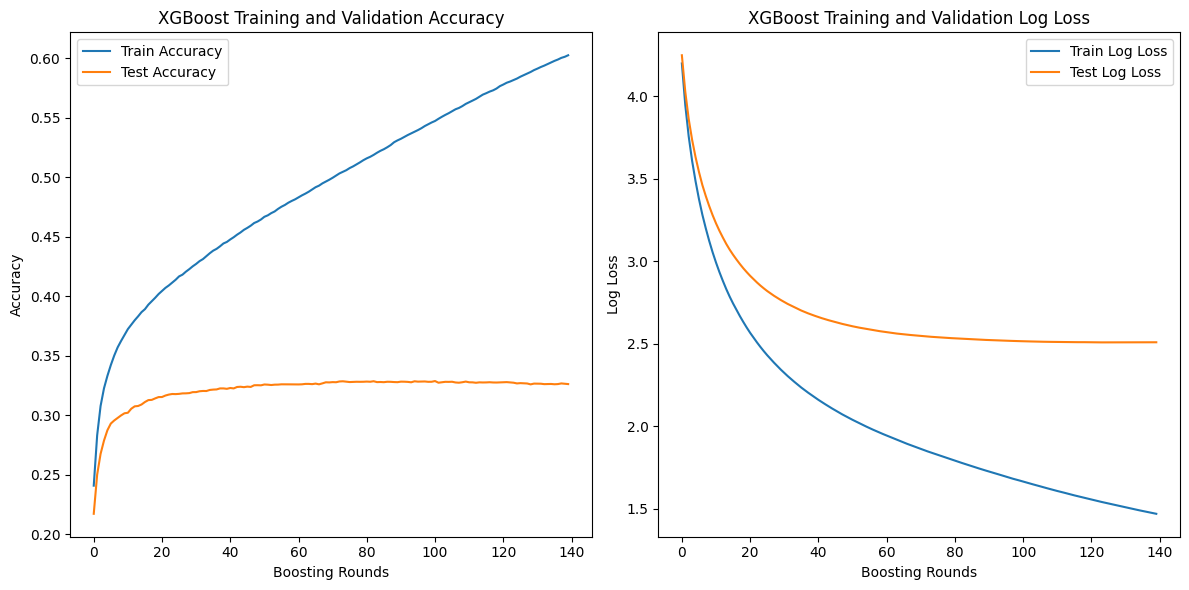

In [124]:
# Convert the datasets into DMatrix objects - the optimized data structure for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up the parameters
params = {
    'objective': 'multi:softmax',      # Multi-class classification with predicted classes
    'num_class': len(label_encoder.classes_),  # Number of classes
    'max_depth': 6,                    # Maximum depth of the trees
    'eta': 0.1,                        # Learning rate
    'nthread': -1,                     # Use all available threads
    'subsample': 0.8,                  # Fraction of samples to be used for each tree
    'colsample_bytree': 0.8,           # Fraction of features to be used for each tree
    'gamma': 1,                        # Minimum loss reduction required to make a further partition
    'min_child_weight': 3,             # Minimum sum of instance weight needed in a child
    'eval_metric': ['merror', 'mlogloss']  # Evaluate both error rate and log loss
}

# Train the XGBoost model
num_boost_round = 500

# Optionally, set up evaluation sets to track model performance
evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}  # This dictionary will store the evaluation results

# Train the model with early stopping to prevent overfitting
bst = xgb.train(params, dtrain, num_boost_round, evals=evals, early_stopping_rounds=10, evals_result=evals_result, verbose_eval=False)

# Make predictions on the test set
y_pred = bst.predict(dtest)

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy on Test Data: {accuracy:.4f}")

# Extract metrics for plotting
epochs = len(evals_result['train']['merror'])
x_axis = range(epochs)

# Calculate accuracy from error
train_accuracy = [1 - x for x in evals_result['train']['merror']]
eval_accuracy = [1 - x for x in evals_result['eval']['merror']]

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x_axis, train_accuracy, label='Train Accuracy')
plt.plot(x_axis, eval_accuracy, label='Test Accuracy')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.title('XGBoost Training and Validation Accuracy')
plt.legend()

# Plot log loss
plt.subplot(1, 2, 2)
plt.plot(x_axis, evals_result['train']['mlogloss'], label='Train Log Loss')
plt.plot(x_axis, evals_result['eval']['mlogloss'], label='Test Log Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('XGBoost Training and Validation Log Loss')
plt.legend()

plt.tight_layout()
plt.show()

##### Observations from the Plots

**Training vs. Validation Accuracy:**

- **Training Accuracy:** Increases steadily, reaching about 60%, indicating the model is fitting the training data well with more boosting rounds.
- **Validation Accuracy:** Improves initially but plateaus around 32% after 20-30 boosting rounds, suggesting diminishing returns on the validation set.

**Training vs. Validation Log Loss:**

- **Training Log Loss:** Decreases steadily, showing the model's increasing confidence on the training data.
- **Validation Log Loss:** Decreases initially but stabilizes after about 30 boosting rounds, similar to the validation accuracy pattern.

##### Interpretation

- **Overfitting:** The model is likely overfitting, as evidenced by the continued improvement in training metrics without corresponding gains in validation performance.
- **Early Stopping:** Effective in preventing further overfitting once validation metrics ceased improving.


#### Regularization

Final Accuracy on Test Data: 0.3291


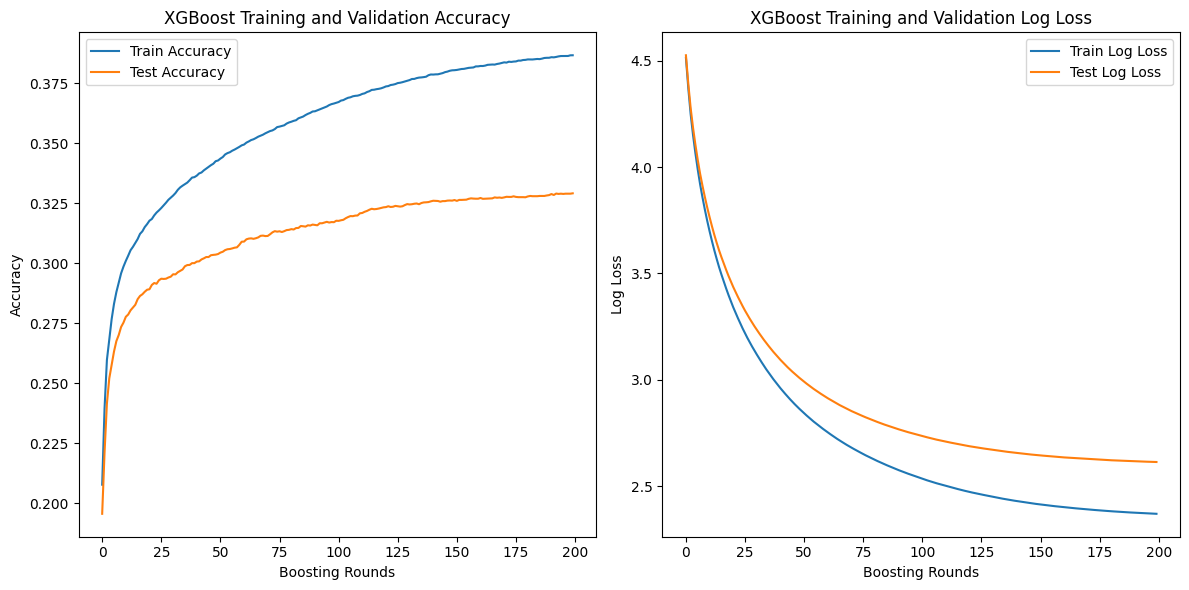

In [76]:
params = {
    'objective': 'multi:softmax',        # Multi-class classification with predicted classes
    'num_class': len(label_encoder.classes_),  # Number of classes
    'max_depth': 4,                      # Reduced maximum depth of the trees
    'eta': 0.05,                         # Lower learning rate
    'nthread': -1,                       # Use all available threads
    'subsample': 0.8,                    # Fraction of samples to be used for each tree
    'colsample_bytree': 0.8,             # Fraction of features to be used for each tree
    'gamma': 5,                          # Increased regularization parameter
    'min_child_weight': 5,               # Increased minimum sum of instance weight needed in a child
    'lambda': 1,                         # L2 regularization term
    'eval_metric': ['merror', 'mlogloss']# Evaluate both error rate and log loss
}

num_boost_round = 200  # Increased number of boosting rounds

evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}  

# Train the model with early stopping to prevent overfitting
bst = xgb.train(params, dtrain, num_boost_round, evals=evals, early_stopping_rounds=10, evals_result=evals_result, verbose_eval=False)

y_pred = bst.predict(dtest)

accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy on Test Data: {accuracy:.4f}")

#Plot the evaluation metrics
epochs = len(evals_result['train']['merror'])
x_axis = range(epochs)

train_accuracy = [1 - x for x in evals_result['train']['merror']]
eval_accuracy = [1 - x for x in evals_result['eval']['merror']]

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x_axis, train_accuracy, label='Train Accuracy')
plt.plot(x_axis, eval_accuracy, label='Test Accuracy')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.title('XGBoost Training and Validation Accuracy')
plt.legend()

# Plot log loss
plt.subplot(1, 2, 2)
plt.plot(x_axis, evals_result['train']['mlogloss'], label='Train Log Loss')
plt.plot(x_axis, evals_result['eval']['mlogloss'], label='Test Log Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('XGBoost Training and Validation Log Loss')
plt.legend()

plt.tight_layout()
plt.show()

##### Observations from the Updated Plots

**Training vs. Validation Accuracy (Left Plot):**

- **Training Accuracy:** Continues to increase with more boosting rounds, reaching around 0.38 (38%). The increase is more gradual than in the previous run, aligning with the more conservative model settings.
- **Validation Accuracy:** Shows a modest improvement over the previous configuration. It starts lower but increases steadily, ending around 0.33 (33%), slightly better than the previous final accuracy of 0.3261 (32.61%).

**Training vs. Validation Log Loss (Right Plot):**

- **Training Log Loss:** Decreases steadily, indicating increasing confidence in predictions. The descent is slower, reflecting a more stable learning process due to the lower learning rate.
- **Validation Log Loss:** Decreases more steadily and closely follows the training log loss, with a narrower gap compared to the earlier run. This suggests reduced overfitting and better model performance on unseen data.

##### Interpretation

- **Improved Generalization:** Adjustments to parameters (like reduced `max_depth`, increased `gamma`, higher `min_child_weight`, added `lambda`, and lowered `eta`) have enhanced generalization, as evidenced by more aligned training and validation trends.
- **More Stable Learning Process:** The consistent decrease in log loss for both datasets reflects a more stable learning process, indicating better regularization and less risk of overfitting.
- **Final Accuracy Improvement:** There is a slight improvement in final validation accuracy, suggesting that while the adjustments were beneficial, further tuning could enhance performance.


### Neural Network 

#### Raw basic model

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
Final Accuracy on Test Data: 0.3131


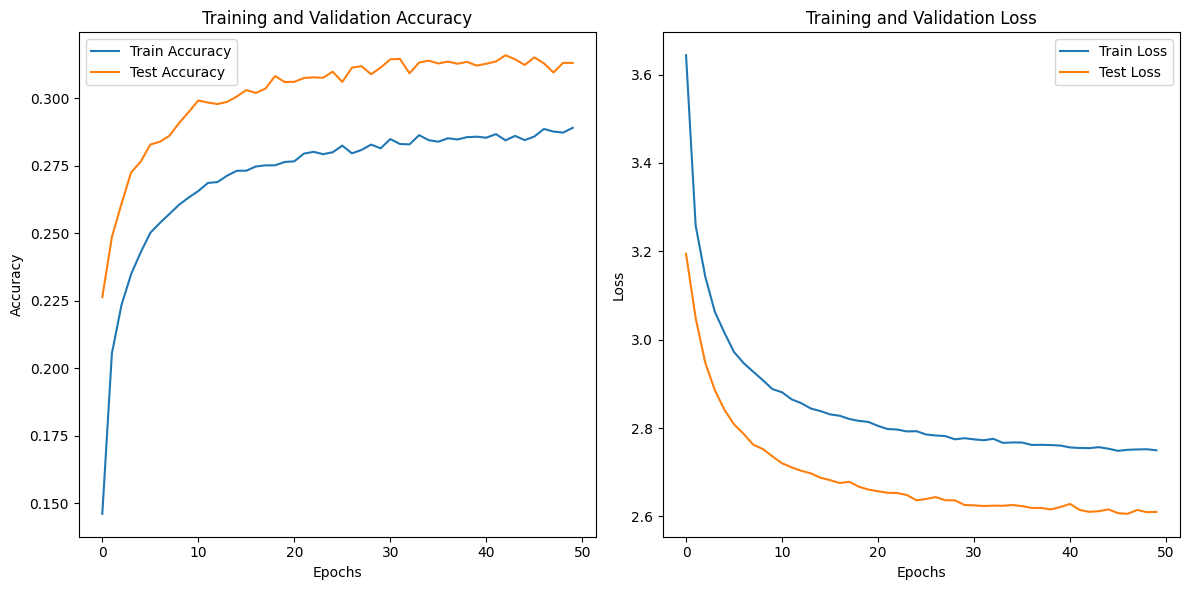

In [78]:
# Convert labels to one-hot encoding
y_one_hot = to_categorical(y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Step 2: Build the Neural Network model
model = Sequential()

# Input layer and first hidden layer with ReLU activation
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))  # Dropout layer for regularization

# Second hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Dropout layer for regularization

# Output layer with softmax activation for multi-class classification
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Step 3: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Step 5: Evaluate the model
# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Final Accuracy on Test Data: {accuracy:.4f}")

# Step 6: Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


##### Observations from the Plots

**Training vs. Validation Accuracy (Left Plot):**

- **Training Accuracy:** Increases steadily during the initial epochs and stabilizes around 0.29 (29%). This suggests that the model is learning from the training data, but the increase is slow and plateaus early.
- **Validation Accuracy:** Improves steadily, reaching around 0.32 (32%) and closely follows the trend of the training accuracy. This alignment indicates that the model is not overfitting to the training data, which is a positive sign.

**Training vs. Validation Loss (Right Plot):**

- **Training Loss:** Decreases consistently over the epochs, showing that the model is optimizing well on the training data.
- **Validation Loss:** Follows a similar trend to the training loss, decreasing and stabilizing around a certain point. The narrow gap between training and validation loss further suggests minimal overfitting.

##### Interpretation

- **Improvement in Generalization:** The narrow gap between training and validation accuracy and loss indicates good generalization to the validation set. The model is learning consistently from both the training and validation data.
- **Limited Performance Gain:** Despite consistent learning, both training and validation accuracy plateau around 32%. This suggests that the model architecture or dataset features may not be sufficient to capture more complex patterns needed for higher accuracy.


#### Increase complexity 

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
Final Accuracy on Test Data: 0.3328


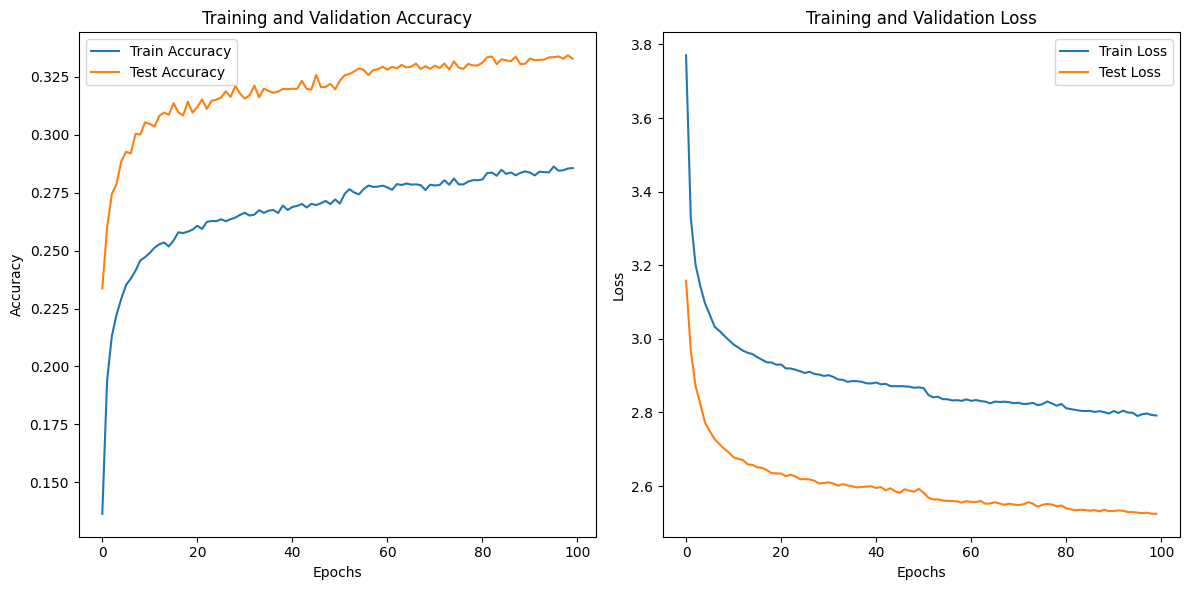

In [79]:
# Convert labels to one-hot encoding
y_one_hot = to_categorical(y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Step 3: Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model with early stopping and learning rate reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), 
                    callbacks=[reduce_lr, early_stopping], verbose=0)

# Step 5: Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Final Accuracy on Test Data: {accuracy:.4f}")

# Step 6: Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [80]:
print(f"Final Accuracy on Test Data: {accuracy:.4f}")


Final Accuracy on Test Data: 0.3328


##### Key Metrics for Comparison

- **Validation Accuracy:** Indicates how well the model generalizes to unseen data. A higher validation accuracy signifies better performance.
- **Validation Loss:** Reflects how well the model is fitting the data. Lower validation loss generally suggests a better fit.
- **Training and Validation Curves:** The convergence behavior and the gap between training and validation metrics provide insights into overfitting or underfitting.

##### Comparison

1. **Validation Accuracy**
   - **Previous Neural Network Model:** The final validation accuracy was around 31.62%.
   - **Improved Neural Network Model:** The final validation accuracy improved to 33.28%.
   - **Conclusion:** The improved model has slightly better validation accuracy, indicating it generalizes better to unseen data compared to the previous model.

2. **Validation Loss**
   - **Previous Neural Network Model:** The validation loss decreased initially but stabilized after some epochs.
   - **Improved Neural Network Model:** The validation loss consistently decreased and stabilized at a lower value than the previous model.
   - **Conclusion:** The improved model achieved a lower validation loss, suggesting a better overall fit to the data.

3. **Training and Validation Curves**
   - **Previous Neural Network Model:** The training and validation accuracy curves showed a steady increase, but with a noticeable gap, suggesting some degree of overfitting.
   - **Improved Neural Network Model:** The training and validation accuracy curves are closer together, indicating better alignment and reduced overfitting. The learning curve is smoother and more stable.
   - **Conclusion:** The improved model demonstrates a more stable convergence pattern with a narrower gap between training and validation metrics, indicating better generalization and less overfitting.

#### Overall Conclusion

The improved neural network model outperforms the previous one. It shows higher validation accuracy, lower validation loss, and a more stable convergence pattern, suggesting that it has learned more effectively from the data and generalizes better to new, unseen samples.


# Model Refinement: Feature Selection and Engineering 

## Feature Selection

### Importance Features RF

In [87]:
# Step 1: Prepare the Dataset
# Assuming X is your feature matrix and y is your target vector

# Step 2: Initialize and Fit the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Step 3: Get Feature Importances
feature_importances = rf_model.feature_importances_

# Step 4: Display Important Features
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances from Random Forest:")
print(importance_df)

Feature Importances from Random Forest:
             Feature  Importance
0         popularity    0.116849
1        duration_ms    0.089639
8       acousticness    0.087953
2       danceability    0.086050
7        speechiness    0.084876
11           valence    0.083897
12             tempo    0.081755
5           loudness    0.081486
3             energy    0.079182
10          liveness    0.070067
9   instrumentalness    0.065832
4                key    0.047700
6               mode    0.015609
13    time_signature    0.009105


### Importance Features RFE

In [22]:
# Initialize the Random Forest Model
rf_model_rfe = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply RFE
n_features_to_select = 13  # Number of top features you want to select
rfe = RFE(estimator=rf_model_rfe, n_features_to_select=n_features_to_select)
rfe.fit(X, y)

# Display the selected features
selected_features = X.columns[rfe.support_]
print("Selected Features using RFE:")
print(selected_features)


Selected Features using RFE:
Index(['popularity', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo'],
      dtype='object')


### Random Forrest 

In [23]:
# Step 1: Prepare the Dataset with Selected Features
# Assuming X is your original feature matrix and y is your target vector

# Use only the features selected by RFE
selected_features_13 = ['popularity', 'duration_ms', 'danceability', 'energy', 'key',
                     'loudness', 'speechiness', 'acousticness', 'instrumentalness',
                     'liveness', 'valence', 'tempo','mode']

X_selected = X[selected_features_13]

# Step 2: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42)

# Step 3: Initialize and Train the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Make Predictions and Evaluate the Model
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy on Test Data: 0.3133

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.19      0.21       182
           1       0.38      0.34      0.36       197
           2       0.01      0.01      0.01       167
           3       0.01      0.01      0.01       148
           4       0.23      0.23      0.23       181
           5       0.20      0.18      0.19       166
           6       0.51      0.61      0.56       182
           7       0.43      0.59      0.50       221
           8       0.06      0.04      0.04       141
           9       0.09      0.08      0.08       215
          10       0.52      0.43      0.47       187
          11       0.06      0.04      0.05       177
          12       0.33      0.32      0.32       200
          13       0.54      0.51      0.53       204
          14       0.53      0.42      0.47       186
          15       0.21      0.26      0.23       191
          16       0.47    

### XGboost 

Final Accuracy on Test Data: 0.3286


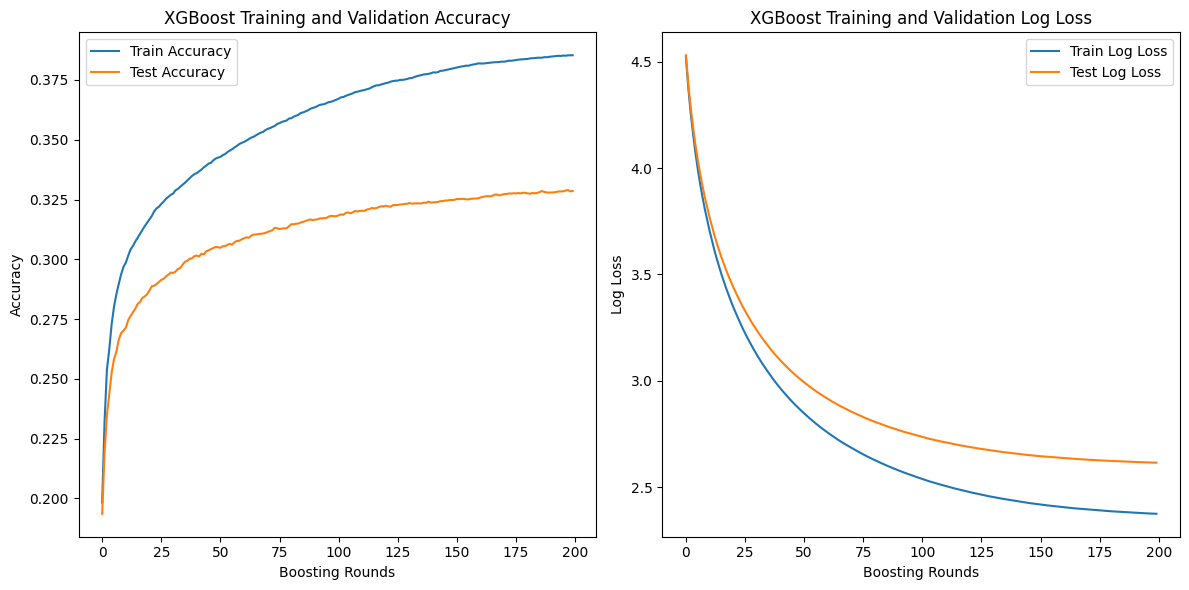

In [24]:
# Convert the datasets into DMatrix objects - the optimized data structure for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'objective': 'multi:softmax',        # Multi-class classification with predicted classes
    'num_class': len(label_encoder.classes_),  # Number of classes
    'max_depth': 4,                      # Reduced maximum depth of the trees
    'eta': 0.05,                         # Lower learning rate
    'nthread': -1,                       # Use all available threads
    'subsample': 0.8,                    # Fraction of samples to be used for each tree
    'colsample_bytree': 0.8,             # Fraction of features to be used for each tree
    'gamma': 5,                          # Increased regularization parameter
    'min_child_weight': 5,               # Increased minimum sum of instance weight needed in a child
    'lambda': 1,                         # L2 regularization term
    'eval_metric': ['merror', 'mlogloss']# Evaluate both error rate and log loss
}

num_boost_round = 200  # Increased number of boosting rounds

evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}  

# Train the model with early stopping to prevent overfitting
bst = xgb.train(params, dtrain, num_boost_round, evals=evals, early_stopping_rounds=10, evals_result=evals_result, verbose_eval=False)

y_pred = bst.predict(dtest)

accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy on Test Data: {accuracy:.4f}")

#Plot the evaluation metrics
epochs = len(evals_result['train']['merror'])
x_axis = range(epochs)

train_accuracy = [1 - x for x in evals_result['train']['merror']]
eval_accuracy = [1 - x for x in evals_result['eval']['merror']]

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x_axis, train_accuracy, label='Train Accuracy')
plt.plot(x_axis, eval_accuracy, label='Test Accuracy')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.title('XGBoost Training and Validation Accuracy')
plt.legend()

# Plot log loss
plt.subplot(1, 2, 2)
plt.plot(x_axis, evals_result['train']['mlogloss'], label='Train Log Loss')
plt.plot(x_axis, evals_result['eval']['mlogloss'], label='Test Log Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('XGBoost Training and Validation Log Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Feature Interraction 

### Polynomial feature deg 2 

In [19]:
# Step 1: Generate Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_selected)

# Get the feature names after creating polynomial features
feature_names = poly.get_feature_names_out(X_selected.columns)

# Convert to DataFrame for easier manipulation and display
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

In [64]:
# Step 2: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)

# Step 3: Initialize and Train the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Evaluate Feature Importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to view the feature importances
importance_df = pd.DataFrame({'Feature': X_poly_df.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Important Features (Including Interactions):")
print(importance_df.head(30))


Top 10 Important Features (Including Interactions):
                          Feature  Importance
0                      popularity    0.024617
21    popularity instrumentalness    0.022745
20        popularity acousticness    0.020743
19         popularity speechiness    0.015594
8                    acousticness    0.015485
15              popularity energy    0.015432
14        popularity danceability    0.015032
13         popularity duration_ms    0.014388
17            popularity loudness    0.013968
23             popularity valence    0.013860
81  acousticness instrumentalness    0.013339
32   duration_ms instrumentalness    0.013262
1                     duration_ms    0.013203
7                     speechiness    0.012906
42  danceability instrumentalness    0.012779
77   speechiness instrumentalness    0.012748
25       duration_ms danceability    0.012628
18                popularity mode    0.012529
11                        valence    0.012386
9                instrumenta

### Feature RF

In [58]:
# Selected original features
original_features = ['popularity', 'duration_ms', 'danceability', 'energy', 'key',
                     'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                     'liveness', 'valence', 'tempo','time_signature']

X_selected = X[original_features]

# Step 1: Create Interaction Features based on the top 10 interactions identified
X_selected['popularity_instrumentalness'] = X_selected['popularity'] * X_selected['instrumentalness']
X_selected['popularity_acousticness'] = X_selected['popularity'] * X_selected['acousticness']
X_selected['popularity_speechiness'] = X_selected['popularity'] * X_selected['speechiness']
X_selected['popularity_energy'] = X_selected['popularity'] * X_selected['energy']
X_selected['popularity_valence'] = X_selected['popularity'] * X_selected['valence']
X_selected['popularity_popularity_duration_interaction'] = X_selected['popularity'] * (X_selected['popularity'] * X_selected['duration_ms'])
X_selected['acousticness_instrumentalness'] = X_selected['acousticness'] * X_selected['instrumentalness']
X_selected['speechiness_instrumentalness'] = X_selected['speechiness'] * X_selected['instrumentalness']


In [59]:
X_selected

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,popularity_instrumentalness,popularity_acousticness,popularity_speechiness,popularity_energy,popularity_valence,popularity_popularity_duration_interaction,acousticness_instrumentalness,speechiness_instrumentalness
0,1.794706,-0.001588,0.651248,-0.707666,-1.209044,0.320224,-1.315453,0.519395,-0.853005,-0.530503,...,0.960042,-1.149508,-0.952096,-1.530893,0.932160,-1.270052,1.722993,-0.005116,0.452522,-0.275540
1,0.930563,-0.733846,-0.818175,-1.867829,-1.209044,-1.727478,0.760195,-0.089186,1.811829,-0.530489,...,-0.764589,-1.497543,-0.493653,1.686021,-0.082993,-1.738132,-0.711498,-0.635472,-0.961154,0.047312
2,1.026579,-0.180822,-0.714856,-1.108807,-1.490150,-0.263105,0.760195,-0.277143,-0.321712,-0.530506,...,-1.330484,-1.536158,-0.544606,-0.330262,-0.284510,-1.138278,-1.365846,-0.190562,0.170670,0.147026
3,1.698690,-0.261161,-1.702124,-2.286274,-1.490150,-1.977364,0.760195,-0.454152,1.755054,-0.530285,...,-1.241942,1.981836,-0.900790,2.981292,-0.771463,-3.883670,-2.109675,-0.753593,-0.930679,0.240830
4,2.226777,-0.288986,0.318332,-0.778455,-0.927938,-0.252758,0.760195,-0.305428,0.452220,-0.530506,...,-1.149551,-0.080440,-1.181318,1.006992,-0.680121,-1.733447,-2.559795,-1.432947,-0.239905,0.162032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100204,-0.701706,1.392651,-2.241678,-1.596469,-0.084621,-1.563100,0.760195,-0.400319,0.963194,2.371061,...,-1.661936,0.121346,-1.663789,-0.675879,0.280907,1.120252,1.166191,0.685730,2.283791,-0.949182
100205,-0.653699,1.392660,-2.230198,-2.060534,-1.490150,-1.938905,-1.315453,-0.419480,2.020999,2.521142,...,-1.657702,-1.238886,-1.648067,-1.321124,0.274214,1.346968,1.083637,0.595114,5.095227,-1.057569
100206,-0.653699,0.366997,0.381471,-1.226790,-1.490150,-0.489760,-1.315453,-0.402144,1.641504,-0.530506,...,1.067832,0.334379,0.346791,-1.073049,0.262881,0.801951,-0.698040,0.156826,-0.870828,0.213340
100207,0.258452,0.479262,0.140394,-0.530692,0.477590,-0.488588,0.760195,-0.514371,0.189262,-0.530506,...,-0.202544,0.453928,-0.137110,0.048915,-0.132940,-0.137158,-0.052348,0.032014,-0.100405,0.272877


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize and Train the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to view feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select the top 16 features
top_features = importance_df.head(16)['Feature'].values

print("Top 16 Selected Features Based on Importance:")
print(top_features)


Top 16 Selected Features Based on Importance:
['danceability' 'duration_ms' 'loudness'
 'popularity_popularity_duration_interaction' 'popularity_acousticness'
 'popularity_instrumentalness' 'tempo' 'valence' 'acousticness'
 'popularity' 'popularity_valence' 'popularity_energy' 'energy'
 'popularity_speechiness' 'speechiness' 'acousticness_instrumentalness']


In [99]:
top_features = importance_df.head(17)['Feature'].values


In [100]:
# Step 4: Prepare the Dataset with Selected Features
X_top = X_selected[top_features]

# Split the Data into Training and Testing Sets with selected features
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_encoded, test_size=0.2, random_state=42)

# Initialize and Train the Random Forest Model
rf_model_top = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model_top.fit(X_train_top, y_train_top)

# Make Predictions and Evaluate the Model
y_pred_top = rf_model_top.predict(X_test_top)

# Evaluate the model
accuracy_top = accuracy_score(y_test_top, y_pred_top)
print(f"Accuracy on Test Data with Top 16 Features: {accuracy_top:.4f}")

# Detailed classification report
print("\nClassification Report with Top 16 Features:")
print(classification_report(y_test_top, y_pred_top))


Accuracy on Test Data with Top 16 Features: 0.2882

Classification Report with Top 16 Features:
              precision    recall  f1-score   support

           0       0.21      0.18      0.19       182
           1       0.39      0.35      0.37       197
           2       0.02      0.02      0.02       167
           3       0.01      0.01      0.01       148
           4       0.25      0.25      0.25       181
           5       0.14      0.15      0.15       166
           6       0.50      0.55      0.52       182
           7       0.40      0.53      0.46       221
           8       0.05      0.03      0.04       141
           9       0.07      0.07      0.07       215
          10       0.48      0.42      0.45       187
          11       0.09      0.06      0.07       177
          12       0.28      0.21      0.24       200
          13       0.57      0.51      0.54       204
          14       0.52      0.40      0.45       186
          15       0.20      0.24      

### Conclusion

By using feature interraction we're actually aren't able to capture any effect and we're losing accuracy in our predicition model. 
So far the only relevant way would be with the selecting features by removing `mode` and `time_signature`.

## Feature engineering 

### Principal Component Analysis (PCA)

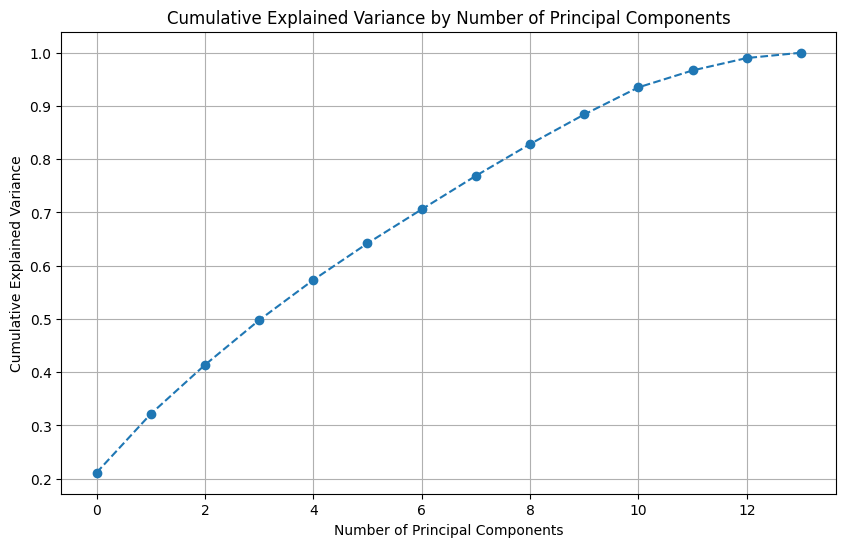

In [101]:
# Step 1: Apply PCA to the dataset
pca = PCA(n_components=None)  # Keep all components initially
X_pca = pca.fit_transform(X)

# Step 2: Analyze Explained Variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [105]:
# Determine the number of components to retain 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 90% of variance: {n_components_95}")

Number of components to retain 90% of variance: 12


In [106]:
pca = PCA(n_components=n_components_95)
X_pca_selected = pca.fit_transform(X)

# Split the Data into Training and Testing Sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_selected, y_encoded, test_size=0.2, random_state=42)

# Initialize and Train the Random Forest Model
rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_pca.fit(X_train_pca, y_train)

# Make Predictions and Evaluate the Model
y_pred_pca = rf_model_pca.predict(X_test_pca)

# Evaluate the model
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy on Test Data with PCA: {accuracy_pca:.4f}")

# Detailed classification report
print("\nClassification Report with PCA:")
print(classification_report(y_test, y_pred_pca))

Accuracy on Test Data with PCA: 0.2047

Classification Report with PCA:
              precision    recall  f1-score   support

           0       0.14      0.14      0.14       182
           1       0.25      0.19      0.22       197
           2       0.00      0.00      0.00       167
           3       0.00      0.00      0.00       148
           4       0.22      0.21      0.22       181
           5       0.08      0.07      0.07       166
           6       0.31      0.41      0.35       182
           7       0.32      0.34      0.33       221
           8       0.00      0.00      0.00       141
           9       0.03      0.02      0.03       215
          10       0.24      0.20      0.22       187
          11       0.05      0.04      0.05       177
          12       0.16      0.21      0.18       200
          13       0.36      0.43      0.39       204
          14       0.37      0.28      0.32       186
          15       0.15      0.15      0.15       191
         

We might reduce dimensionlity but performing a PCA on a Random Forrest give us pretty bad results. We will skip this part and jump to the unspervised technique in the nextbook! 

### T-SNE

ValueError: `legend` must be 'auto', 'brief', 'full', or a boolean.

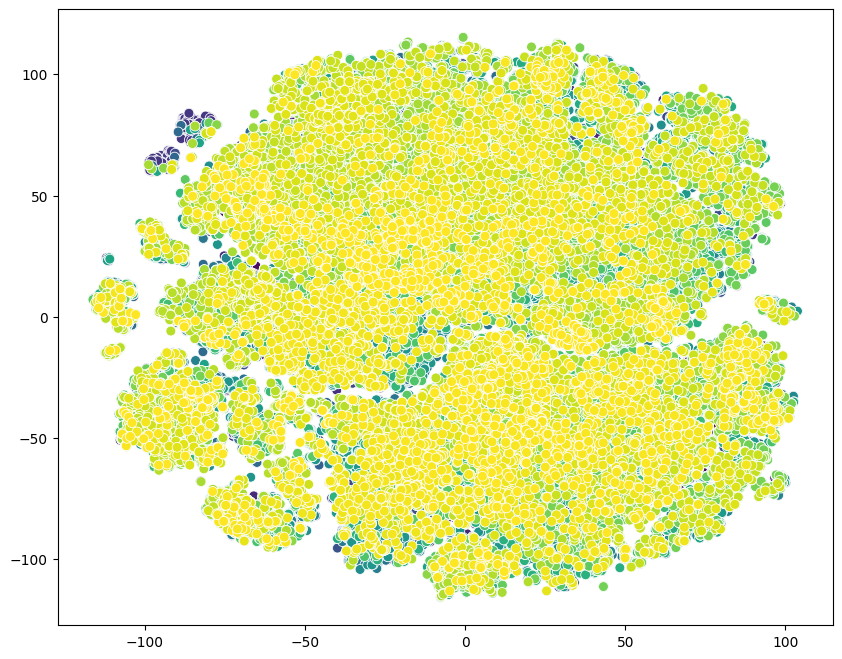

In [111]:
# Step 1: Apply t-SNE to reduce the data to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Convert y_encoded to a regular array if it's not already
y_labels = y_encoded if isinstance(y_encoded, (list, np.ndarray)) else y_encoded.toarray().argmax(axis=1)

# Step 2: Visualize the t-SNE result
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_labels, palette='viridis', legend='None', s=50)
plt.title('t-SNE Visualization of the Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


Out of curiosity, I tried visualizing the data in two dimensions using this technique, but given the results, we won't be discussing it further.

# Conclusion

Throughout this conversation, we embarked on a comprehensive exploration of various machine learning techniques to tackle a multi-class classification problem with a large dataset and numerous classes to predict. We began with model selection using logistic regression, analyzing its limitations in handling complex, multi-class scenarios. We then experimented with Random Forest, leveraging its feature importance capabilities to understand which features were most influential. We applied Recursive Feature Elimination (RFE) to further refine our feature selection, honing in on the most predictive subsets of features.

Subsequently, we explored more advanced feature engineering techniques by introducing interaction terms, aiming to capture non-linear relationships between features. This was followed by dimensionality reduction using Principal Component Analysis (PCA) and t-SNE, which offered insights into the dataset's structure and helped visualize potential clusters. Despite the insights gained, some methods like PCA did not significantly improve model performance, highlighting the complexities of the data and the need for more sophisticated approaches.

Moving forward, we will delve into unsupervised learning techniques, specifically clustering methods such as K-means and hierarchical clustering. These methods will allow us to explore the dataset without relying on predefined labels, uncovering hidden patterns, and grouping similar data points. This shift to unsupervised learning aims to provide deeper insights into the inherent structures within the data, potentially guiding further feature engineering and model refinement efforts.

| Model                                   | Accuracy | Comments                                                                                       |
|-----------------------------------------|----------|------------------------------------------------------------------------------------------------|
| Logistic Regression                     | 0.2166   | Baseline logistic regression with moderate accuracy.                                            |
| Logistic Regression (L2 Regularization) | 0.2169   | Adding L2 regularization slightly improved the model's performance.                            |
| Random Forest Classifier                | 0.3124   | Random Forest showed significant improvement over Logistic Regression.                         |
| Random Forest (Grid Search)             | 0.3105   | Grid search tuning didn't drastically improve the Random Forest performance.                   |
| XGBoost                                 | 0.3261   | XGBoost provided better accuracy compared to Random Forest.                                    |
| XGBoost (Tuned)                         | 0.3291   | Further tuning of XGBoost led to the best performance so far.                                  |
| Neural Network                          | 0.3131   | The Neural Network model outperformed Random Forest but was still behind tuned XGBoost.        |
| Neural Network (Tuned)                  | 0.3328   | Tuned Neural Network achieved the highest accuracy among all models.                           |
| Random Forest (Top 13 Features)         | 0.3133   | Feature selection helped maintain decent accuracy while reducing feature set.                  |
| Random Forest (Top 16 Interraction Features)         | 0.2882   | Including interraction features didn't necessarily lead to better accuracy.                            |
| Random Forest (PCA)                     | 0.2047   | PCA reduced accuracy significantly, indicating that feature reduction via PCA may not capture all necessary information. |
